In [12]:
import os
os.chdir("..")

from PIL import Image
import torch
import clip
from omegaconf import OmegaConf
from pytorch_lightning import seed_everything

from scflow.trainer_module import TrainerModuleSCFlow
import matplotlib.pyplot as plt


torch.cuda.set_device(0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device} (CUDA available: {torch.cuda.is_available()})")

Device: cuda (CUDA available: True)


#### Static parameters (change only if needed)

In [13]:
# stay constant
config_path = "./configs/inference.yaml"   # Config file path
resume_checkpoint = "./ckpts/scflow_last.ckpt"   # Model checkpoint path
val_step_num = 1                        # FM step count
test_vis = True                          # Visualization toggle
unclip_ckpt = "./ckpts/sd21-unclip-l.ckpt" # UnCLIP checkpoint
seed = 2025                              # Random seed

#### Load model

In [14]:
def exists(val):
   return val is not None

def build_cfg():
    """Build minimal cfg for model loading."""
    cfg = OmegaConf.load(config_path)
    cfg.val_step_num = val_step_num
    cfg.image_mix_path = None
    cfg.image_c_path = None
    cfg.image_s_path = None
    cfg.result_path = "notetbook_results"
    cfg.unclip_ckpt = unclip_ckpt
    return cfg

def load_module_once():
    global module
    if 'module' in globals() and module is not None:
        print("[Reuse] Model already loaded.")
        return module
    seed_everything(seed)
    cfg_for_load = build_cfg()  # Build minimal config for loading the model
    ckpt_path = resume_checkpoint
    module_local = TrainerModuleSCFlow.load_from_checkpoint(
        checkpoint_path=ckpt_path,
        fm_cfg=cfg_for_load.model.fm,
        test_vis=test_vis,
        unclip_ckpt=cfg_for_load.unclip_ckpt,
        val_step_num=cfg_for_load.val_step_num,
        strict=False, map_location='cpu'
    )
    module_local = module_local.to(device)
    module_local.eval()
    module = module_local
    print(f"[Load] Model loaded from {ckpt_path}")
    return module

module = load_module_once()

Seed set to 2025


Loading model from ./ckpts/sd21-unclip-l.ckpt
ImageEmbeddingConditionedLatentDiffusion: Running in v-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 1024 and using 5 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 1024 and using 10 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and us

/export/home/pima/miniconda3/envs/dift/lib/python3.10/site-packages/lightning/pytorch/core/saving.py:191: Found keys that are in the model state dict but not in the checkpoint: ['unclip_model.betas', 'unclip_model.alphas_cumprod', 'unclip_model.alphas_cumprod_prev', 'unclip_model.sqrt_alphas_cumprod', 'unclip_model.sqrt_one_minus_alphas_cumprod', 'unclip_model.log_one_minus_alphas_cumprod', 'unclip_model.sqrt_recip_alphas_cumprod', 'unclip_model.sqrt_recipm1_alphas_cumprod', 'unclip_model.posterior_variance', 'unclip_model.posterior_log_variance_clipped', 'unclip_model.posterior_mean_coef1', 'unclip_model.posterior_mean_coef2', 'unclip_model.model.diffusion_model.time_embed.0.weight', 'unclip_model.model.diffusion_model.time_embed.0.bias', 'unclip_model.model.diffusion_model.time_embed.2.weight', 'unclip_model.model.diffusion_model.time_embed.2.bias', 'unclip_model.model.diffusion_model.label_emb.0.0.weight', 'unclip_model.model.diffusion_model.label_emb.0.0.bias', 'unclip_model.model.

[Load] Model loaded from ./ckpts/scflow_last.ckpt


#### CLIP encoder

In [15]:
class CLIPEncoder:
    def __init__(self, device=None):
        if device is None:
            device = "cuda" if torch.cuda.is_available() else "cpu"
        self.device = device
        self.model, self.preprocess = clip.load('ViT-L/14', device=self.device)
        self.model.eval()

    @torch.no_grad()
    def encode_image(self, image_path):
        image = Image.open(image_path).convert('RGB')
        image_input = self.preprocess(image).unsqueeze(0).to(self.device)
        features = self.model.encode_image(image_input)
        return features

encoder = CLIPEncoder(device=device)
print("CLIP encoder ready.")


CLIP encoder ready.


#### Forward inference

##### Edit the path of the input images

In [16]:
# ---- Change these for each run ----
image_c_path = "image_samples/Cyberpunk/02316.png"
image_s_path = "image_samples/Drip_Painting/09728.png"

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 40 timesteps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 40 timesteps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 40 timesteps


Sampling: 100%|██████████| 1/1 [00:02<00:00,  2.21s/it]


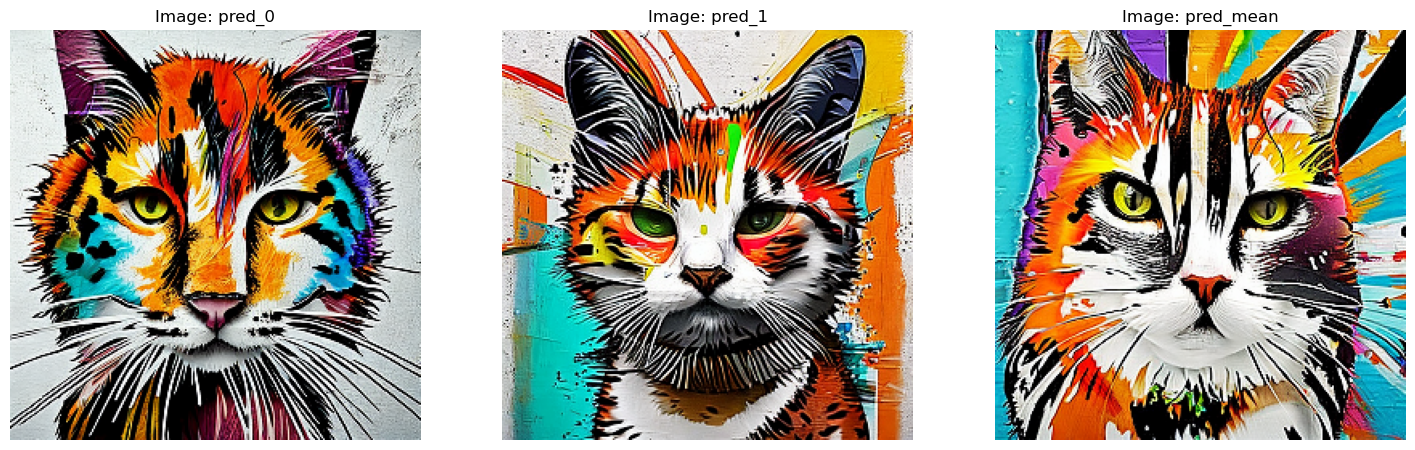

In [17]:

# ---- Inference ----
assert image_c_path and image_s_path, "Please set content and style image paths."

with torch.no_grad():
    features_c = encoder.encode_image(image_c_path).unsqueeze(0).to(device=module.device, dtype=module.dtype)
    features_s = encoder.encode_image(image_s_path).unsqueeze(0).to(device=module.device, dtype=module.dtype)

    clip_emb = torch.cat([features_c, features_s], dim=2)
    clip_pred = module.predict_forward(clip_emb)

    preds = {
        "0": clip_pred[:, :, :768],
        "1": clip_pred[:, :, 768:],
        "mean": (clip_pred[:, :, :768] + clip_pred[:, :, 768:]) / 2.0
    }

# ---- Visualization ----
fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Adjust the figure size if needed

for i, (key, tensor) in enumerate(preds.items()):
    img = module.get_sample_to_vis(tensor, save=False)
    
    axes[i].imshow(img)
    axes[i].axis('off')  
    axes[i].set_title(f"Image: pred_{key}")  

plt.show()


#### Reverse inference

##### Edit the path of the input image

In [18]:
# ---- Change these for each run ----
image_mix_path = "image_samples/Drip_Painting/02316.png"

Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 40 timesteps


Sampling:   0%|          | 0/1 [00:00<?, ?it/s]

Data shape for DDIM sampling is (1, 4, 96, 96), eta 0.0
Running DDIM Sampling with 40 timesteps


Sampling: 100%|██████████| 1/1 [00:02<00:00,  2.22s/it]


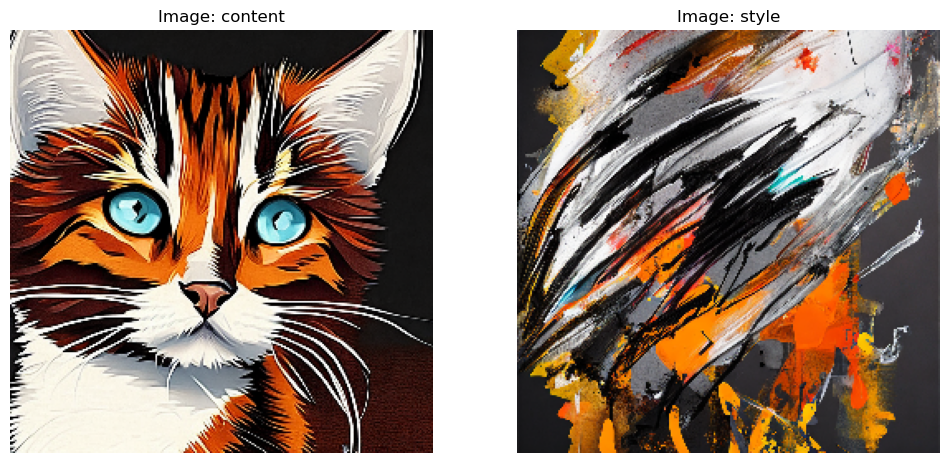

In [19]:
import matplotlib.pyplot as plt

# ---- Inference ----
assert image_mix_path, "Please set mixed image path."

with torch.no_grad():
    features = encoder.encode_image(image_mix_path).unsqueeze(0).to(device=module.device, dtype=module.dtype)
    clip_target = torch.cat([features, features], dim=2)
    clip_pred = module.predict_reverse(clip_target)

    preds = {
        "content": clip_pred[:, :, :768],
        "style": clip_pred[:, :, 768:]
    }

# ---- Visualization ----
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

for i, (key, tensor) in enumerate(preds.items()):
    img = module.get_sample_to_vis(tensor, save=False)
    
    axes[i].imshow(img)
    axes[i].axis('off')  
    axes[i].set_title(f"Image: {key}")  

plt.show()